In [20]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import scipy
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score # use to calculate accuracy
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf



train = pd.read_csv('P:/Kaggle/20181026_Titanic/train.csv')
test = pd.read_csv('P:/Kaggle/20181026_Titanic/test.csv')
print(train.head())
print(test.head())
print(train.shape)
print(test.shape)

data = pd.concat([train,test])
print(data.shape)
data.tail()


C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [35]:
data['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [3]:
# find dtypes
print(data.dtypes)

# missing values
missing_col = pd.merge((pd.DataFrame(data.isnull().sum()/len(data))),pd.DataFrame(data.dtypes),left_index=True,right_index=True,how='left')
missing_col.columns = ['Missing%','DataType']
print(missing_col)

# drop id,name and ticket
data_drop = data.drop(columns=['Name','PassengerId','Ticket'])

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object
             Missing% DataType
Age          0.200917  float64
Cabin        0.774637   object
Embarked     0.001528   object
Fare         0.000764  float64
Name         0.000000   object
Parch        0.000000    int64
PassengerId  0.000000    int64
Pclass       0.000000    int64
Sex          0.000000   object
SibSp        0.000000    int64
Survived     0.319328  float64
Ticket       0.000000   object


In [4]:
# check target:survived
data_drop['Survived'].fillna(0,inplace=True)
data_drop['Survived'].value_counts(dropna=False)

0.0    967
1.0    342
Name: Survived, dtype: int64

In [6]:
# take a look at how many levels for each categorical variables
data_cat = data_drop.select_dtypes(include=['object'])

for var in data_cat.columns.tolist():
    print(var+" has "+str(data_cat[var].value_counts(dropna=False).size)+" levels")
    print(pd.DataFrame(data_cat[var].value_counts(dropna=False)).head(10))
    
# find categorical variables which has missing values
categorical_var_missing = data_cat.loc[:,data_cat.isnull().any()].columns.tolist()
print(categorical_var_missing)

# replace missing values with 'Missing'
for var in categorical_var_missing:
    data_drop[var].fillna('Missing',inplace=True)
    
data_drop.isnull().sum()

Cabin has 187 levels
                 Cabin
Missing           1014
C23 C25 C27          6
B57 B59 B63 B66      5
G6                   5
F33                  4
F2                   4
D                    4
C78                  4
B96 B98              4
C22 C26              4
Embarked has 4 levels
         Embarked
S             914
C             270
Q             123
Missing         2
Sex has 2 levels
        Sex
male    843
female  466
[]


Age         263
Cabin         0
Embarked      0
Fare          1
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived      0
dtype: int64

In [7]:
# find default missing values for numeric var
print(data_drop.select_dtypes(exclude='object').head())

# check missing values
missing_num_var= data_drop.select_dtypes(exclude='object').isnull().sum().sort_values(ascending=False)
print(missing_num_var[missing_num_var>0])

num_var_missing = (missing_num_var[missing_num_var>0]).index.tolist()

num_var_missing.remove('Fare')
print(num_var_missing)

    Age     Fare  Parch  Pclass  SibSp  Survived
0  22.0   7.2500      0       3      1       0.0
1  38.0  71.2833      0       1      1       1.0
2  26.0   7.9250      0       3      0       1.0
3  35.0  53.1000      0       1      1       1.0
4  35.0   8.0500      0       3      0       0.0
Age     263
Fare      1
dtype: int64
['Age']


In [8]:
data_2_num = data_drop.select_dtypes(exclude='object')
default_missing= data_drop.copy()
print(data_2_num.head())

    Age     Fare  Parch  Pclass  SibSp  Survived
0  22.0   7.2500      0       3      1       0.0
1  38.0  71.2833      0       1      1       1.0
2  26.0   7.9250      0       3      0       1.0
3  35.0  53.1000      0       1      1       1.0
4  35.0   8.0500      0       3      0       0.0


In [9]:
## handle missing values for numeric variables
########def to find default value start#########################################
def replacedefault_value(numtable,table,var,var_response):
    data = numtable[var_response].groupby([numtable[var].astype(str)]).mean().sort_values().to_frame()
    print(data.head())

# change index of data as a column in data
    data.reset_index(level=0,inplace=True)
    print(data.head())

# find the row number when variable = missing 
# missing row is a numpy array, change to list before append together
    missingrow = list(data.loc[data[var] == 'nan',:].index.values)
    missingrow_prior =  list(data.loc[data[var] == 'nan',:].index.values -1 )
    missingrow_after =  list(data.loc[data[var] == 'nan',:].index.values +1 )

#append missingrow, prior and after together
    missingrow_closer = missingrow_prior+missingrow_after
    data2 = data.loc[missingrow_closer,:]
    print(data2)

    data2['Missing_mean'] = (data.loc[data[var]
                                      == 'nan',var_response].values[0])
# get absolute value 
    data2['Missing_mean_diff_abs'] = (abs(data2[var_response] - 
                                          data2['Missing_mean']))
    print(data2)
# set default
    default = data2.loc[(min(data2['Missing_mean_diff_abs']) 
                         == data2['Missing_mean_diff_abs']),
                        var].values[0]
    
    type_var = numtable[var].dtype
    default_T = float(default)
    print(var,'default value is',default_T) 

    # replace nan by default value
    print(table.loc[numtable[var].isnull() ,var][:6])
    table.loc[table[var].isnull(),var] = default_T
    print(table[var][:6])
########def to find default value end#########################################

for var in num_var_missing:
    replacedefault_value(data_2_num,default_missing, var,'Survived')

# all value false then false, if one value is true then return true
default_missing.isnull().any().sum()

      Survived
Age           
0.17       0.0
24.5       0.0
26.5       0.0
28.5       0.0
30.5       0.0
    Age  Survived
0  0.17       0.0
1  24.5       0.0
2  26.5       0.0
3  28.5       0.0
4  30.5       0.0
     Age  Survived
41  23.0  0.192308
43  26.0  0.200000
     Age  Survived  Missing_mean  Missing_mean_diff_abs
41  23.0  0.192308      0.197719               0.005411
43  26.0  0.200000      0.197719               0.002281
Age default value is 26.0
5    NaN
17   NaN
19   NaN
26   NaN
28   NaN
29   NaN
Name: Age, dtype: float64
0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5    26.0
Name: Age, dtype: float64


1

In [10]:
# fill Fare missing values with its mean
default_missing['Fare'].fillna(data['Fare'].mean(),inplace=True)

In [11]:
default_missing.isnull().sum()
default_missing.isnull().any()

Age         False
Cabin       False
Embarked    False
Fare        False
Parch       False
Pclass      False
Sex         False
SibSp       False
Survived    False
dtype: bool

In [12]:
# correlation matrix
default_missing.head()
num_var = default_missing.select_dtypes(exclude='object')
print(num_var.head())

col = num_var.columns.tolist()
col.remove('Survived')
col.insert(0,'Survived')
col
num_var[col].corr()

    Age     Fare  Parch  Pclass  SibSp  Survived
0  22.0   7.2500      0       3      1       0.0
1  38.0  71.2833      0       1      1       1.0
2  26.0   7.9250      0       3      0       1.0
3  35.0  53.1000      0       1      1       1.0
4  35.0   8.0500      0       3      0       0.0


,Survived,Age,Fare,Parch,Pclass,SibSp
Survived,1.000000,-0.051073,0.173630,0.054908,-0.244686,-0.014375
Age,-0.051073,1.000000,0.185943,-0.120084,-0.388685,-0.188449
Fare,0.173630,0.185943,1.000000,0.221522,-0.558477,0.160224
Parch,0.054908,-0.120084,0.221522,1.000000,0.018322,0.373587
Pclass,-0.244686,-0.388685,-0.558477,0.018322,1.000000,0.060832
SibSp,-0.014375,-0.188449,0.160224,0.373587,0.060832,1.000000


(1309, 3)
(1309, 4)
['Cabin', 'Embarked', 'Sex']
       Cabin  target_mean
0        A10     0.000000
1        A11     0.000000
2        A14     0.000000
3        A16     1.000000
4        A18     0.000000
5        A19     0.000000
6        A20     1.000000
7        A21     0.000000
8        A23     1.000000
9        A24     0.000000
10       A26     1.000000
11       A29     0.000000
12       A31     1.000000
13       A32     0.000000
14       A34     0.333333
15       A36     0.000000
16        A5     0.000000
17        A6     1.000000
18        A7     0.000000
19        A9     0.000000
20       B10     0.000000
21      B101     1.000000
22      B102     0.000000
23       B11     0.000000
24       B18     1.000000
25       B19     0.000000
26       B20     1.000000
27       B22     0.500000
28       B24     0.000000
29       B26     0.000000
..       ...          ...
157      E36     1.000000
158      E38     0.000000
159  E39 E41     0.000000
160      E40     1.000000
161      E44   

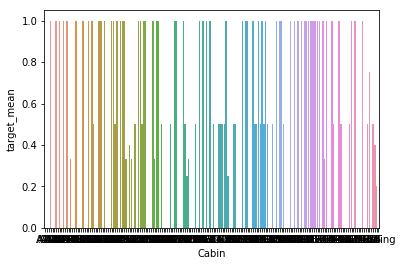

  Embarked  target_mean
0        C     0.344444
1  Missing     1.000000
2        Q     0.243902
3        S     0.237418


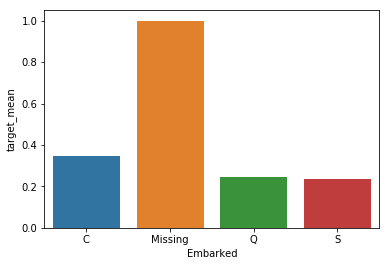

      Sex  target_mean
0  female       0.5000
1    male       0.1293


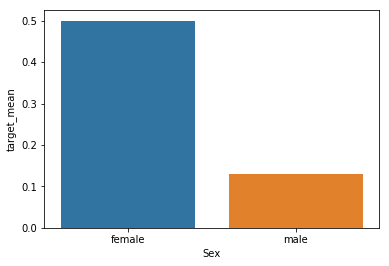

In [13]:
# get the distribution of categorical variables vs Survived
final_cha_var = default_missing.select_dtypes(include='object')
target = default_missing['Survived']
target.head()
print(final_cha_var.shape)

# concatenate loan_final_cha_var with target together by columns, axis=1 by column
# default is outjoin by index
cha_var = pd.concat([final_cha_var,target],axis=1)
print(cha_var.shape)
cha_var.head()

# find avarage target based on each bins of all categorical variables
def avarage_target_group(var,target):
    table = cha_var.groupby(var).agg({target:'mean'}).reset_index()
    table.rename({target:'target_mean'},inplace=True,axis=1)
    print(table)
    sns.barplot(x=var,y='target_mean',data=table)
    plt.show()

# print all character variable list
cha_var_list = cha_var.columns.tolist()
del cha_var_list[-1]
print(cha_var_list)

for var in cha_var_list:
    avarage_target_group(var,'Survived')

In [14]:
# get_dummy to change categorical data dummy variables
cat = default_missing.select_dtypes(include='object')
cat_col = cat.columns.tolist()
print(cat_col)


for var in cat_col:
    t = pd.DataFrame(default_missing.groupby(var).agg({'Survived':np.mean})).reset_index()
    t.columns=[var,var+'_Mean']
    default_missing=pd.merge(default_missing,t,on=var,how='left')

default_missing.head()


# data_after_dummies = pd.get_dummies(default_missing,columns=cat_col)
# data_after_dummies.dtypes
# data_after_dummies.isnull().sum().sum()

['Cabin', 'Embarked', 'Sex']


,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Cabin_Mean,Embarked_Mean,Sex_Mean
0,22.0,Missing,S,7.2500,0,3,male,1,0.0,0.203156,0.237418,0.1293
1,38.0,C85,C,71.2833,0,1,female,1,1.0,0.500000,0.344444,0.5000
2,26.0,Missing,S,7.9250,0,3,female,0,1.0,0.203156,0.237418,0.5000
3,35.0,C123,S,53.1000,0,1,female,1,1.0,0.500000,0.237418,0.5000
4,35.0,Missing,S,8.0500,0,3,male,0,0.0,0.203156,0.237418,0.1293


In [15]:
# drop original cat
final_t = default_missing.drop(columns=cat_col)
final_t.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Cabin_Mean,Embarked_Mean,Sex_Mean
0,22.0,7.2500,0,3,1,0.0,0.203156,0.237418,0.1293
1,38.0,71.2833,0,1,1,1.0,0.500000,0.344444,0.5000
2,26.0,7.9250,0,3,0,1.0,0.203156,0.237418,0.5000
3,35.0,53.1000,0,1,1,1.0,0.500000,0.237418,0.5000
4,35.0,8.0500,0,3,0,0.0,0.203156,0.237418,0.1293


In [16]:
# separate to train and test


train_data, test_data, train_label, test_label = train_test_split(final_t.drop('Survived', axis=1), 
                                                    final_t['Survived'], test_size=0.33)

train_data.columns.tolist()

['Age',
 'Fare',
 'Parch',
 'Pclass',
 'SibSp',
 'Cabin_Mean',
 'Embarked_Mean',
 'Sex_Mean']

In [18]:
# randomr forest
# # all the data fit to scikit learn model need to change to matrix 
# # Gini index select the best variables that creates most homogeneous/simiar sub-nodes to split parent nodes

modelrf = RandomForestClassifier(random_state=0,
                              n_estimators=100,
                              max_features=6,
                              max_depth=5)
training_start = time.perf_counter()
modelrf.fit(train_data,train_label)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = modelrf.predict(test_data)
prediction_end = time.perf_counter()

acc_rfc = (preds == test_label).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start


print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 84.72
Time consumed for training: 0.165 seconds
Time consumed for prediction: 0.01042 seconds


In [19]:
# xgboost 
xgb = XGBClassifier(n_estimators=100,
                   max_depth=5,
                   learning_rate=0.2,
                   seed=123,
                   n_jobs=8)

training_start = time.perf_counter()
xgb.fit(train_data.as_matrix(), train_label.as_matrix())
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = xgb.predict(test_data.as_matrix())
prediction_end = time.perf_counter()

acc_xgb = (preds == test_label).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start


print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 81.48
Time consumed for training: 0.028
Time consumed for prediction: 0.00109 seconds


C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [27]:
# neural network
# use the same number of neurons as input variables as starting points
# the weights are initialed using a small gaussian(normal distribution) randomnumber. 

# from keras.models import Sequential
# from keras.layers import Dense
# traing label and test label must be integer
train_label = train_label.map(int)
test_label= test_label.map(int)

# only output errors
tf.logging.set_verbosity(tf.logging.ERROR)

# define initial hyperparameters
# one epoch= one forward pass and one backpropagation of all training examples(one epoch could have multiple iterations)
# batch_size is the number of training observation for one iteration. Higher numbers take more momory space.
# number of iterations = number of passing: one pass = one forward pass and one backward pass
# example: if we have 1000 training example, one batch size is 500, then it will take 2 iteration completed one epoch
batch_size = 1 # means number of training observations used for one iteration
train_steps = 1000 # training_step is equal to iteration 
hidden_units=[10,10] # mean the first hidden layer has 10 nodes and the second layer has 10 nodes as well
train_data.keys()


# create a numeric column for every column of the training set
feature_cols = []
for key in train_data.keys():
     feature_cols.append(tf.feature_column.numeric_column(key=key))

print(feature_cols)

# build model with input function
# n_classes=2 mean binary problem
# shuffle whether to read record in random order
dnn = tf.estimator.DNNClassifier(hidden_units=hidden_units, feature_columns=feature_cols, n_classes=2)

input_fn = tf.estimator.inputs.pandas_input_fn(x=train_data, 
                                               y=train_label,
                                               batch_size=batch_size,
                                               shuffle=False)

# fit the DNN to the training data
training_start = time.perf_counter()
dnn.train(input_fn = input_fn, steps=train_steps)
training_end = time.perf_counter()

# predict test data
predict_input_func = tf.estimator.inputs.pandas_input_fn(x=test_data, shuffle=False)

prediction_start = time.perf_counter()
preds = dnn.predict(input_fn=predict_input_func)
prediction_end = time.perf_counter()

# evaluate results
final_preds = []
for pred in preds:
    final_preds.append(pred['class_ids'][0])
    
acc_dnn = (final_preds == test_label).sum().astype(float) / len(final_preds)*100
dnn_train_time = training_end-training_start
dnn_prediction_time = prediction_end-prediction_start

print("Dense Neural Network Classifier's prediction accuracy is: %3.2f" % (acc_dnn))
print("Time consumed for training: %4.3f seconds" % (dnn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (dnn_prediction_time))



[_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Pclass', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='SibSp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Cabin_Mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Embarked_Mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Sex_Mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]
Dense Neural Network Classifier's prediction accuracy is: 71.99
Time consumed for training: 5.371 seconds
Time consumed for prediction: 0.00006 seconds


In [28]:
# combine model performance result 
results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'DNN'],
    'Score': [ acc_xgb, acc_rfc, acc_dnn],
    'Runtime Training': [ xgb_train_time, rfc_train_time,  dnn_train_time],
    'Runtime Prediction': [ xgb_prediction_time, rfc_prediction_time, dnn_prediction_time]})

result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df


,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,84.722222,0.165217,0.010424
XGBoost,81.481481,0.028045,0.001094
DNN,71.990741,5.371439,0.000055


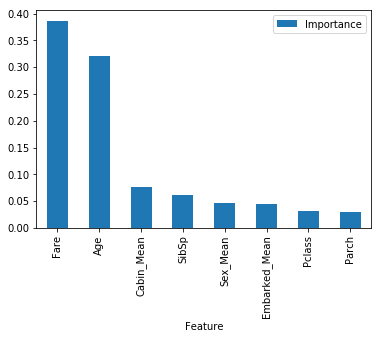

In [29]:
# show xgboost variable importance: based on how often the variable used to split trees 
importances = pd.DataFrame({
    'Feature': train_data.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances[:10]

importances[:10].plot.bar()

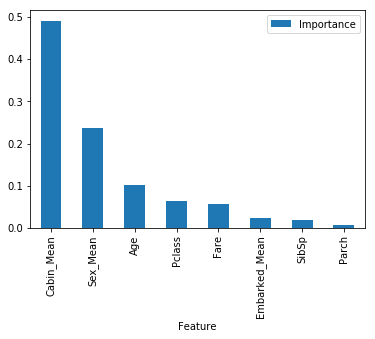

In [30]:
# show three algothim variable importance of random forest: use the accuracy decreses if the variable is exclude out(shuffle) as the measurement
importances = pd.DataFrame({
    'Feature': train_data.columns,
    'Importance': modelrf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances[:10]

importances[:10].plot.bar()

C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gqbwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[0. 0. 0. 1. 0.]
col_0     0.0  1.0
Survived          
0         292   19
1          47   74
43
45
     Pred_Prob                     Survived
          size      amin      amax      sum
Rank                                       
1         43.0  0.029159  0.052187        4
2         43.0  0.052204  0.059422        3
3         43.0  0.059839  0.068134        2
4         43.0  0.068506  0.071403        4
5         43.0  0.071403  0.078674        1
6         43.0  0.078757  0.188838        5
7         43.0  0.190747  0.294568       15
8         43.0  0.296752  0.533981       17
9         43.0  0.535666  0.647136       30
10        45.0  0.663344  1.000000       40
recall/sensitivity is: 0.61157
specificity is: 0.93891
precision is: 0.79570
AUROC is: 0.8572054954691611


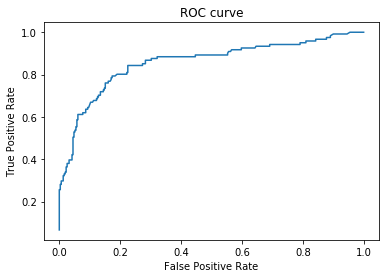

In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# rf model evaluation
# confusion matrix
test_data2 = test_data.copy()
preds = modelrf.predict(test_data.as_matrix())
print(preds[:5])
cm = pd.DataFrame(pd.crosstab(test_label,preds))
print(cm)

# Predicted Probablity vs Actual

predict_proba= modelrf.predict_proba(test_data.as_matrix())
test_data2['Pred_Prob'] = predict_proba[:,1]

PredProb_Actual = pd.merge(test_data2,pd.DataFrame(test_label),left_index=True,right_index=True,how='left')
PredProb_Actual_Col = PredProb_Actual[['Survived','Pred_Prob']]
PredProb_Actual_Col.sort_values(by=['Pred_Prob'],inplace=True)

X1=round(PredProb_Actual_Col.shape[0]/10)
X2=PredProb_Actual_Col.shape[0] - X1*9
print(X1)
print(X2)
PredProb_Actual_Col['Rank']= np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],[X1, X1, X1, X1, X1, X1, X1, X1, X1,X2])
PredProb_Actual_Col.head()
print(PredProb_Actual_Col.groupby(['Rank']).agg({'Pred_Prob':[np.size,np.min,np.max],'Survived':[np.sum]}))

# Sensitivity, Specificity, Precision
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

print("recall/sensitivity is: %3.5f" % (cm.loc[1,1]/(cm.loc[1,0]+cm.loc[1,1])) ) # among all the acutal positive, how much are predicted as positive
print("specificity is: %3.5f" % (cm.loc[0,0]/(cm.loc[0,0]+cm.loc[0,1])) ) # among all the actual negative, how much are predicted as negative
print("precision is: %3.5f" % (cm.loc[1,1]/(cm.loc[0,1]+cm.loc[1,1])) ) # among all the predicted as positive, how many of them are actual positive

# AUROC

print("AUROC is:",roc_auc_score(test_label, predict_proba[:,1]))
fpr, tpr, _ = roc_curve(test_label, predict_proba[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [37]:
# get rf model accuracy on both train and test dataset to check overfitting
preds = modelrf.predict(test_data)
preds_t = modelrf.predict(train_data)

acc_rfc_t = (preds_t == train_label).sum().astype(float) / len(preds_t)*100
acc_rfc = (preds == test_label).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start


print("Scikit-Learn's Random Forest Classifier's prediction accuracy(train) is: %3.2f" % (acc_rfc_t))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy(test) is: %3.2f" % (acc_rfc))

Scikit-Learn's Random Forest Classifier's prediction accuracy(train) is: 86.66
Scikit-Learn's Random Forest Classifier's prediction accuracy(test) is: 84.72
